In [177]:
data_dir = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

In [178]:
import os

folders in directory

In [179]:
os.listdir(data_dir)

['benign', 'normal', 'malignant']

In [180]:
for cls in os.listdir(data_dir):
    print (cls,':',len(os.listdir(data_dir + '/' + cls)))
    

benign : 891
normal : 266
malignant : 421


In [181]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)

In [182]:
len(dataset)
dataset[0]

(<PIL.Image.Image image mode=RGB size=562x471 at 0x7F703CA41610>, 0)

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline

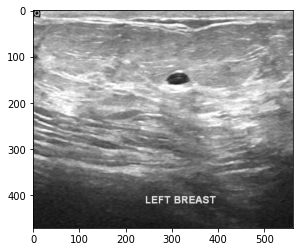

In [184]:
img, label = dataset[0]
plt.imshow(img)

resizing images because we need to have size of image same

In [185]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64),tt.RandomCrop(64),tt.ToTensor()]))

giving right dimensions to display images

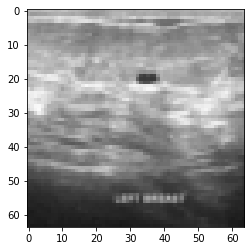

In [186]:
img, label = dataset[0]
plt.imshow(img.permute((1,2,0)))

values to divide in to train test

In [187]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size,val_size




(1421, 157)

splitting in to train test

In [188]:
from torch.utils.data import random_split
train_ds,valid_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

(1421, 157)

shuffling the train and getting them in to dataloader

In [189]:
from torch.utils.data import DataLoader
batch_size = 128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,batch_size,num_workers=4,pin_memory=True)



making grid system to display

In [190]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

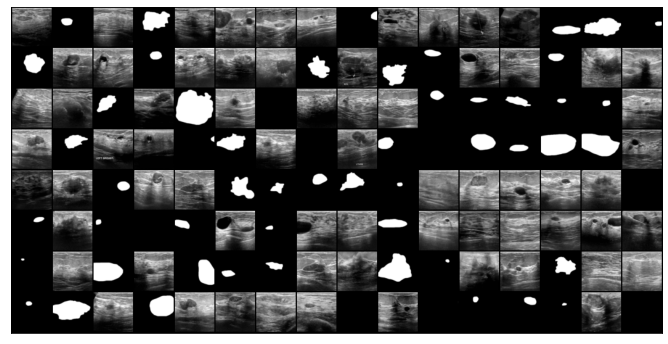

In [191]:
show_batch(train_dl)

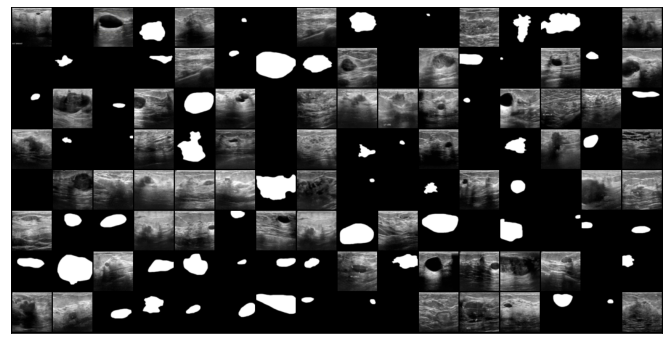

In [192]:
show_batch(valid_dl)

utility functions and classes

In [193]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [194]:
torch.cuda.is_available()

True

In [195]:
device = get_default_device()

In [196]:
device

device(type='cuda')

In [197]:
img, label = dataset[0]

In [198]:
img.device

device(type='cpu')

In [199]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [200]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

model and training utilities

In [201]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [202]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model

In [203]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [204]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

passing one batch of input tensor through the model

In [205]:
for batch in train_dl:
    images,labels = batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds = model(images)
    print('preds.shape',preds.shape)
    #print(preds)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 3])


training my model

In [206]:
history = [evaluate(model,valid_dl)]
history

[{'val_loss': 1.1198694705963135, 'val_acc': 0.19490841031074524}]

In [207]:
history += fit(5,0.001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.8214, val_loss: 0.9976, val_acc: 0.4806
Epoch [1], train_loss: 0.7750, val_loss: 0.8400, val_acc: 0.5431
Epoch [2], train_loss: 0.6833, val_loss: 0.7581, val_acc: 0.6017
Epoch [3], train_loss: 0.6478, val_loss: 0.8306, val_acc: 0.5994
Epoch [4], train_loss: 0.5961, val_loss: 0.7485, val_acc: 0.6713


In [208]:
history += fit(5,0.0001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.5371, val_loss: 0.5012, val_acc: 0.7856
Epoch [1], train_loss: 0.5427, val_loss: 0.5462, val_acc: 0.7660
Epoch [2], train_loss: 0.4878, val_loss: 0.4748, val_acc: 0.7934
Epoch [3], train_loss: 0.4754, val_loss: 0.3905, val_acc: 0.8223
Epoch [4], train_loss: 0.4644, val_loss: 0.3870, val_acc: 0.8490


In [209]:
history += fit(5,0.0001,model,train_dl,valid_dl,torch.optim.SGD)

Epoch [0], train_loss: 0.4125, val_loss: 0.3532, val_acc: 0.8623
Epoch [1], train_loss: 0.4178, val_loss: 0.3412, val_acc: 0.8623
Epoch [2], train_loss: 0.4735, val_loss: 0.3415, val_acc: 0.8662
Epoch [3], train_loss: 0.4335, val_loss: 0.3558, val_acc: 0.8529
Epoch [4], train_loss: 0.4964, val_loss: 0.3544, val_acc: 0.8568


In [210]:
history += fit(5,0.00001,model,train_dl,valid_dl,torch.optim.SGD)

Epoch [0], train_loss: 0.4028, val_loss: 0.3323, val_acc: 0.8662
Epoch [1], train_loss: 0.4614, val_loss: 0.3375, val_acc: 0.8568
Epoch [2], train_loss: 0.4500, val_loss: 0.3356, val_acc: 0.8490
Epoch [3], train_loss: 0.4810, val_loss: 0.3412, val_acc: 0.8662
Epoch [4], train_loss: 0.4583, val_loss: 0.3310, val_acc: 0.8702


In [211]:
history += fit(5,0.00001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4125, val_loss: 0.3703, val_acc: 0.8451
Epoch [1], train_loss: 0.4064, val_loss: 0.3164, val_acc: 0.8780
Epoch [2], train_loss: 0.3967, val_loss: 0.3377, val_acc: 0.8741
Epoch [3], train_loss: 0.4492, val_loss: 0.3062, val_acc: 0.8741
Epoch [4], train_loss: 0.3934, val_loss: 0.3152, val_acc: 0.8741


In [212]:
history += fit(5,0.000001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4493, val_loss: 0.3206, val_acc: 0.8702
Epoch [1], train_loss: 0.3921, val_loss: 0.3258, val_acc: 0.8662
Epoch [2], train_loss: 0.3861, val_loss: 0.3522, val_acc: 0.8545
Epoch [3], train_loss: 0.4012, val_loss: 0.3313, val_acc: 0.8490
Epoch [4], train_loss: 0.3822, val_loss: 0.3284, val_acc: 0.8451


In [213]:
history += fit(5,0.0001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4585, val_loss: 0.4355, val_acc: 0.8318
Epoch [1], train_loss: 0.4380, val_loss: 0.4700, val_acc: 0.8028
Epoch [2], train_loss: 0.4699, val_loss: 0.5368, val_acc: 0.7950
Epoch [3], train_loss: 0.3976, val_loss: 0.3104, val_acc: 0.8952
Epoch [4], train_loss: 0.5438, val_loss: 0.3285, val_acc: 0.8318


In [214]:
history += fit(5,0.0001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.4025, val_loss: 0.2823, val_acc: 0.8874
Epoch [1], train_loss: 0.3464, val_loss: 0.3071, val_acc: 0.8396
Epoch [2], train_loss: 0.3987, val_loss: 0.2787, val_acc: 0.9046
Epoch [3], train_loss: 0.3765, val_loss: 0.3139, val_acc: 0.8679
Epoch [4], train_loss: 0.3331, val_loss: 0.3273, val_acc: 0.8702


In [215]:
history += fit(5,0.00001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.3057, val_loss: 0.2392, val_acc: 0.9085
Epoch [1], train_loss: 0.3484, val_loss: 0.2972, val_acc: 0.8584
Epoch [2], train_loss: 0.2861, val_loss: 0.2591, val_acc: 0.9124
Epoch [3], train_loss: 0.3392, val_loss: 0.2543, val_acc: 0.9085
Epoch [4], train_loss: 0.3098, val_loss: 0.2783, val_acc: 0.8929


In [216]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

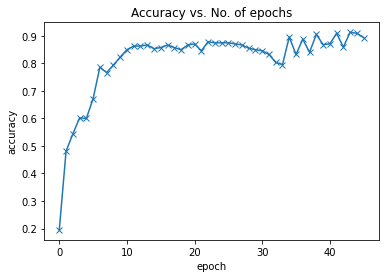

In [217]:
plot_accuracies(history)

In [218]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


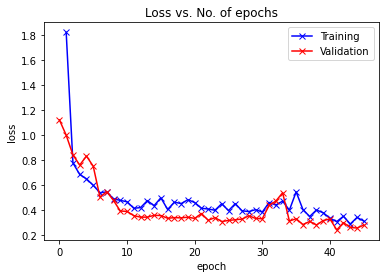

In [219]:
plot_losses(history)

record the results

In [221]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [222]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)


Target: benign
Prediction: benign


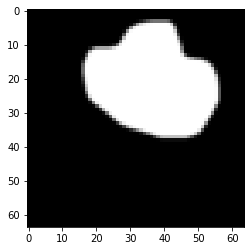

In [223]:
show_image_prediction(*valid_ds[100])

Target: benign
Prediction: benign


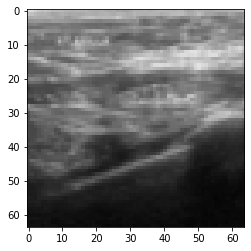

In [225]:
show_image_prediction(*valid_ds[20])

Target: benign
Prediction: benign


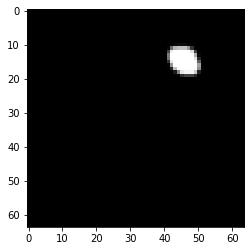

In [226]:
show_image_prediction(*valid_ds[120])

Target: benign
Prediction: benign


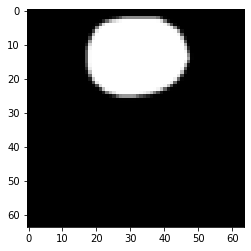

In [227]:
show_image_prediction(*valid_ds[140])

Target: benign
Prediction: benign


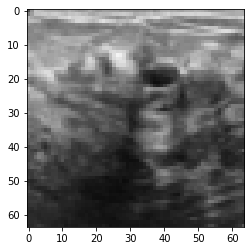

In [235]:
show_image_prediction(*valid_ds[129])

Target: benign
Prediction: benign


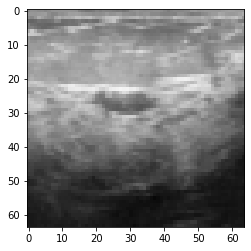

In [239]:
show_image_prediction(*valid_ds[156])

Target: malignant
Prediction: malignant


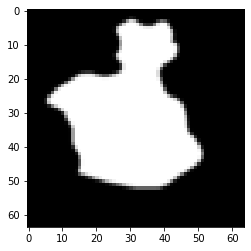

In [244]:
show_image_prediction(*valid_ds[52])

Target: normal
Prediction: normal


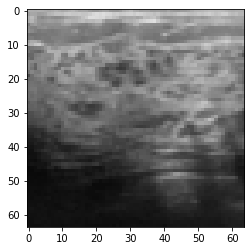

In [247]:
show_image_prediction(*valid_ds[55])

Target: malignant
Prediction: malignant


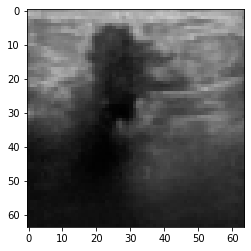

In [248]:
show_image_prediction(*valid_ds[61])